# Création du modèle

Nous créons ici le modèle qui servira pour répondre à l'objectif. Nous avons donc travaillé sur *Colab* afin d'entrainer rapidement notre modèle sous Exécution GPU. Le dataset2.zip a été importé dans *Colab* et dézippé, contenant le dossier data_sign2. Après traitement des images, leur association avec leur label et leur séparation en Trainset et Testset, le modèle a pu être lancé.

Quelques essaies ont été réalisés, mais rencontrant un *overfitting*, nous avons décidé d'ajouter des Dropout, certes très élevés, mais qui ont permis d'obtenir un modèle présentant des résultats satisfaisants lors des tests vidéos.

## Importation du dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
zip_path = '/content/gdrive/My Drive/microsoft_ia/Sign/dataset2.zip'

# On copie le fichier zip complet sur notre environnement
!cp "{zip_path}" .

# On dezippe le fichier dans l'environnement
!unzip -q dataset2.zip

# On supprime le fichier zip de l'environnement
!rm dataset2.zip

# On verifie que les images ont bien été importés dans notre environnement viruel.
!ls

replace data_sign2/A/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: data_sign2  gdrive  sample_data


In [ ]:
import cv2
import os

In [ ]:
data_direction = "data_sign2"
categories = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','_SPACE']

for category in categories:
    path = os.path.join(data_direction, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))

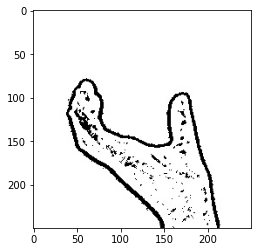

Nombre de Catégories : 27
Shape Image : (250, 250, 3)


In [ ]:
import matplotlib.pyplot as plt

IMG_SIZE = 128

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
new_array = cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB)
plt.imshow(img_array, cmap ='gray')
plt.show()

print(f"Nombre de Catégories : {len(categories)}")
print(f"Shape Image : {img_array.shape}")

## Création de notre liste de données

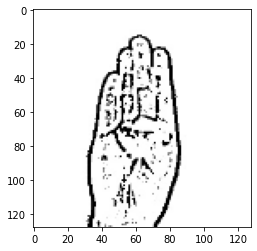

In [ ]:
data_list = []

def create_data_list():
    for category in categories:
        path = os.path.join(data_direction, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            data_list.append([new_array, class_num])

create_data_list()

import numpy as np

plt.imshow(np.uint8(data_list[344][0]), cmap='gray')
plt.show()

In [ ]:
len(data_list)

8100

In [ ]:
import random

random.shuffle(data_list)

x = []
y = []

for feature, label in data_list:
    x.append(feature)
    y.append(label)

from sklearn.model_selection import train_test_split

x_app, x_val, y_app, y_val = train_test_split(x, y, test_size=0.2, shuffle=True)

x_app = np.array(x_app).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y_app = np.array(y_app)

x_val = np.array(x_val).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y_val = np.array(y_val)

x_app = x_app.astype('float')/255
x_val = x_val.astype('float')/255

print("x_app.shape :\t ", x_app.shape)
print("x_val.shape :\t ", x_val.shape)
print("y_app.shape :\t ", y_app.shape)
print("y_val.shape :\t ", y_val.shape)

x_app.shape :	  (6480, 128, 128, 3)
x_val.shape :	  (1620, 128, 128, 3)
y_app.shape :	  (6480,)
y_val.shape :	  (1620,)


#### Encodage des labels

In [ ]:
from tensorflow import keras

y_app = keras.utils.to_categorical(y_app, 27)
y_val = keras.utils.to_categorical(y_val, 27)

print("y_app.shape :\t ",y_app.shape)
print("y_val.shape :\t ",y_val.shape)

y_app.shape :	  (6480, 27)
y_val.shape :	  (1620, 27)


## Création du CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout

model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(Dropout(0.8))

model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(Dropout(0.8))

model.add(tf.keras.layers.Flatten())
model.add(Dropout(0.8))

model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(27, activation='softmax'))

model.compile(optimizer ='adam',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

#### Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmentation = ImageDataGenerator(rotation_range=10,
                                zoom_range=0.2,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                shear_range=0.15,
                                horizontal_flip=False,
                                vertical_flip=False,
                                fill_mode="nearest")

In [ ]:
history = model.fit(augmentation.flow(x_app, y_app), epochs=25, validation_data=(x_val, y_val))

Epoch 1/25
203/203 [==============================] - 96s 449ms/step - loss: 3.7410 - accuracy: 0.0612 - val_loss: 1.5342 - val_accuracy: 0.5265
Epoch 2/25
203/203 [==============================] - 89s 435ms/step - loss: 2.0184 - accuracy: 0.3290 - val_loss: 1.0307 - val_accuracy: 0.7630
Epoch 3/25
203/203 [==============================] - 89s 436ms/step - loss: 1.6376 - accuracy: 0.4398 - val_loss: 0.6932 - val_accuracy: 0.7704
Epoch 4/25
203/203 [==============================] - 88s 434ms/step - loss: 1.3600 - accuracy: 0.5272 - val_loss: 0.5037 - val_accuracy: 0.8272
Epoch 5/25
203/203 [==============================] - 88s 434ms/step - loss: 1.1502 - accuracy: 0.6020 - val_loss: 0.3321 - val_accuracy: 0.9265
Epoch 6/25
203/203 [==============================] - 88s 434ms/step - loss: 1.0705 - accuracy: 0.6364 - val_loss: 0.2666 - val_accuracy: 0.9383
Epoch 7/25
203/203 [==============================] - 89s 438ms/step - loss: 0.9370 - accuracy: 0.6801 - val_loss: 0.2465 - val_ac

In [ ]:
model.save('/content/gdrive/My Drive/microsoft_ia/Sign/model5_sign')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/microsoft_ia/Sign/model5_sign/assets


## Evaluation

In [ ]:
from sklearn.metrics import accuracy_score
y_val = np.argmax(y_val, axis=1)
y_pred = model.predict_classes(x_val)
print('Précision sur les données Test : ', accuracy_score(y_val, y_pred))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Précision sur les données Test :  0.9623456790123457


#### Ajout du graphe Loss et Val_Loss

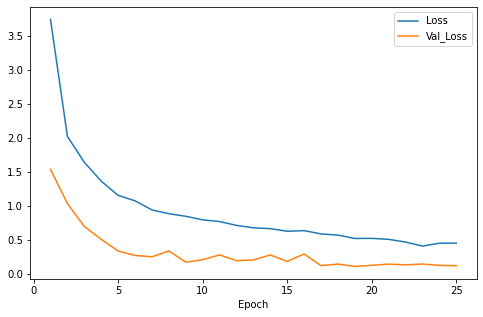

In [13]:
epoch = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
loss = [3.7410, 2.0184, 1.6376, 1.3600, 1.1502, 1.0705, 0.9370, 0.8810, 0.8429, 0.7906, 0.7651, 0.7092, 0.6732, 0.6610, 0.6225, 0.6319, 0.5832, 0.5662, 0.5162, 0.5179, 0.5036, 0.4637, 0.4039, 0.4466, 0.4477]
val_loss = [1.5342, 1.0307, 0.6932, 0.5037, 0.3321, 0.2666, 0.2465, 0.3326, 0.1674, 0.2026, 0.2747, 0.1896, 0.2002, 0.2734, 0.1783, 0.2893, 0.1162, 0.1399, 0.1047, 0.1216, 0.1392, 0.1285, 0.1402, 0.1201, 0.1158]

import pandas as pd
import matplotlib.pyplot as plt

history = pd.DataFrame(({"Epoch":epoch, "Loss":loss, "Val_Loss":val_loss}))
plt.figure(figsize=(8,5))
plt.xlabel("Epoch")
plt.plot(history['Epoch'], history['Loss'], label="Loss")
plt.plot(history['Epoch'], history['Val_Loss'], label="Val_Loss")
plt.legend()
plt.show()

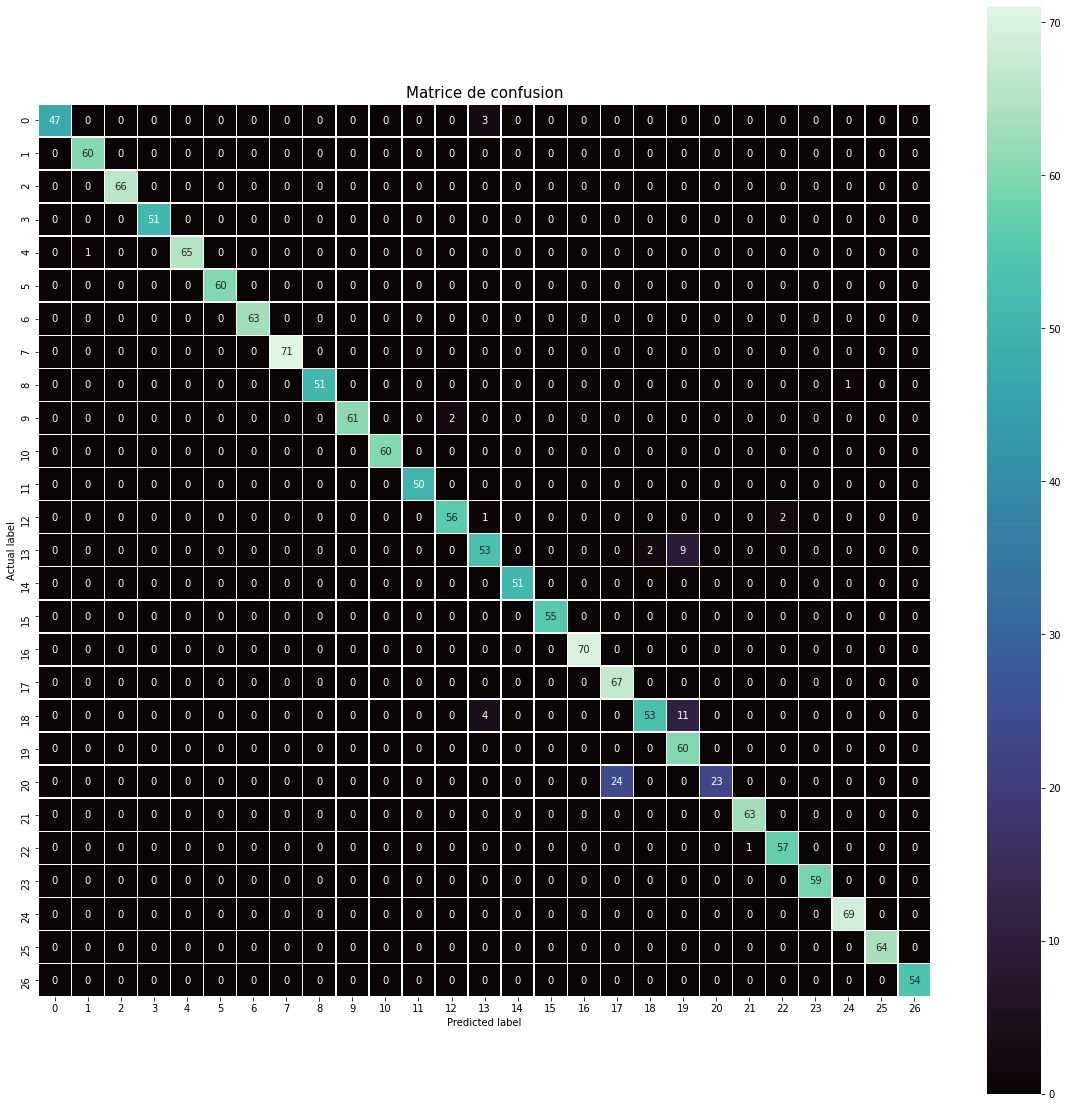

In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

cf_matrix = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(20,20))
sns.heatmap(cf_matrix, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'mako');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Matrice de confusion", size = 15)
plt.show()


La plupart des lettres sont bien classées sauf pour la lettre U dont la moitié des images se retrouve dans la classe R. Nous avons tout de même constaté que le modèle différenciait bien ces deux lettres lors des test live.